# New code version

In [1]:
from scipy.linalg import lstsq
def _state_vector_to_orbit(orbit, correction_vector, parameter_constraints=(False,False,False), **kwargs):
    """
    :param orbit:
    :param correction_vector:
    :param preconditioning:
    :param parameter_constraints:
    :param kwargs:
    :return:
    """
    correction_vector = correction_vector.reshape(-1, 1)
    mode_shape, mode_size = orbit.state.shape, orbit.state.size
    d_modes = correction_vector[:mode_size]
    # slice the changes to parameters from vector
    d_params = correction_vector[mode_size:].ravel()

    for i, constrained in enumerate(parameter_constraints):
        if constrained or (i == len(d_params)):
            d_params = np.insert(d_params, i, 0)
    dT, dL, dS = d_params
    correction_orbit = orbit.__class__(state=np.reshape(d_modes, mode_shape), state_type='modes', T=dT, L=dL, S=dS)
    return correction_orbit


In [15]:
read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\none_1001.h5").to_h5(directory='local')

In [24]:
np.zeros([1, 1])

array([[0.]])

In [21]:
%%timeit
rfft(np.random.randn(1024, 1024), norm='ortho', axis=0, workers=-1)

53.2 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
rfft(np.random.randn(1024, 1024), norm='ortho', axis=0)

69 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
np.random.seed(0)
np.random.randn()

In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
# from scipy.fft import irfft,rfft,rfftn,irfftn,fftn,ifftn,fft,ifft,fft2,rfft2
import itertools
from math import pi
# from orbithunter.glue import *
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
from functools import lru_cache
from orbithunter.arrayops import swap_modes
%matplotlib inline

import time
sr_orbit = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\none_000_021.h5")
orbit = OrbitKS(state=sr_orbit.state, state_type=sr_orbit.state_type, T=sr_orbit.T, L=sr_orbit.L+0.01).convert(to='modes')
self = orbit.copy()
other = orbit.spatiotemporal_mapping()

In [4]:
%%timeit
assert self.state_type == 'modes', 'Convert to spatiotemporal Fourier mode basis before computations.'
modes = self.state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)

dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx4, modes)
linear_modes = dt + dx2 + dx4

# Return Spatial derivative with 1/2 factor. The conversion to modes does not do anything unless original
# state has discrete symmetry
orbit_field = self.convert(to='field')
pseudospectral_modes = orbit_field.statemul(orbit_field).convert(to='modes').state
# Return Spatial derivative with 1/2 factor. The conversion to modes does not do anything unless original
# state has discrete symmetry
nonlinear_modes = 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters),
                                    pseudospectral_modes), dimension='space')

mapping_modes = linear_modes + nonlinear_modes
self.__class__(state=mapping_modes, state_type='modes', T=self.T, L=self.L)

212 µs ± 6.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%%timeit
assert self.state_type == 'modes', 'Convert to spatiotemporal Fourier mode basis before computations.'
modes = self.state
# initialize fourier frequency multipliers for derivatives
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)

# multiply to produce derivatives of modes
dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx4, modes)
# aggregate into linear term of KSe
linear_modes = dt + dx2 + dx4

# compute nonlinear term 1/2 * (u**2)_x
orbit_field = self.convert(to='field')
pseudospectral_modes = orbit_field.statemul(orbit_field).convert(to='modes').state
nonlinear_modes = 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters),
                                    pseudospectral_modes), dimension='space')

# combine linear and nonlinear parts for full mapping
mapping_modes = linear_modes + nonlinear_modes

208 µs ± 4.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%%timeit
other.state

62 ns ± 0.583 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [12]:
%%timeit
other.state.ravel()

265 ns ± 4.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
%%timeit
assert self.state_type == 'modes', 'Convert to spatiotemporal Fourier mode basis before computations.'
# Compute the linear terms u_t + u_xx + u_xxxx
linear_modes = (self.dt() + self.dx(power=2)
                + self.dx(power=4))

# compute nonlinear term 1/2 * (u**2)_x
orbit_field = self.convert(to='field')
nonlinear_modes = orbit_field.pseudospectral(orbit_field)
mapping_modes = linear_modes + nonlinear_modes
# self.__class__(state=mapping_modes, state_type='modes', T=self.T, L=self.L)

248 µs ± 5.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
assert self.state_type == 'modes', 'Convert to spatiotemporal Fourier mode basis before computations.'
linear_modes = (self.dt(return_modes=True) + self.dx(power=2, return_modes=True)
                + self.dx(power=4, return_modes=True))

orbit_field = self.convert(to='field')
nonlinear_modes = orbit_field.pseudospectral(orbit_field, return_modes=True)
mapping_modes = linear_modes + nonlinear_modes
# self.__class__(state=mapping_modes, state_type='modes', T=self.T, L=self.L)

222 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
%%timeit
orbit.dt(return_modes=True)

14.8 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
test = np.ones(9)
test.dot(test)

9.0

In [37]:
%%timeit
orbit.dt()

18.3 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
# power = 1
9.1 µs ± 222 w/ , 5.82 µs ± 223  w/o

In [ ]:
# power = 2
9.1 µs ± 222 w/ , 5.82 µs ± 223  w/o

In [2]:
import time
sr_orbit = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\none_000_021.h5")
orbit = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L21p95_T72p33.h5", state_type='modes')
orbit.L += 0.01
self = orbit.copy()
other = orbit.spatiotemporal_mapping()

In [4]:
%%timeit

(31, 30)

In [4]:
repr(orbit)

'RelativeOrbitKS({"residual": "5.93e-04", "N": 32, "M": 32, "T": "7.23e+01", "L": "2.2e+01", "S": "3.06e+00"})'

In [5]:
orbit.spatiotemporal_mapping().norm() - 0.03443032290778314

0.0

In [6]:
self.rmatvec(other).norm() - 0.07471894992978417

0.0

In [7]:
self.matvec(other).norm() - 35.51666470002293

0.0

In [8]:
self.rmatvec(other).L, self.rmatvec(other).T, self.rmatvec(other).S

(5.08180393309556e-07, -1.387991997803139e-06, -6.820633216230298e-05)

In [7]:
step_size = 1
mapping = orbit.spatiotemporal_mapping()
residual = mapping.residual(apply_mapping=False)
dx = orbit.rmatvec(mapping, parameter_constraints=(False, False, False),
                   preconditioning=True)
next_orbit = orbit.increment(dx, stepsize=-1.0*step_size)
next_mapping = next_orbit.spatiotemporal_mapping()
next_residual = next_mapping.residual(apply_mapping=False)

while next_residual >= residual:
    step_size = 0.5*step_size
    next_orbit = orbit.increment(dx, stepsize=-1.0*step_size)
    next_mapping = next_orbit.spatiotemporal_mapping()
    next_residual = next_mapping.residual(apply_mapping=False)
    if step_size <= 10**-8:
        print('u dun goofed')
else:
    next_orbit, next_mapping, next_residual

In [8]:
print(next_orbit.norm()-22.76238282853366, next_orbit.T-72.3340672503825,
      next_orbit.L-21.968938342724154, next_orbit.S-3.0562703767577277)


0.0 0.0 0.0 0.0


In [9]:
print(next_mapping.norm()-0.027464641646541842, next_mapping.T- 72.3340672503825,
      next_mapping.L-21.968938342724154, next_mapping.S-0.0)

0.0 0.0 0.0 0.0


In [10]:
next_residual - 0.00037715327038648027

0.0

In [11]:
### this is original
# self.rmatvec(other).L, self.rmatvec(other).T, self.rmatvec(other).S

In [13]:
t0=time.time()
result = converge(orbit, method='adj', atol=10**-6, verbose=True)
t1=time.time()
print('adj desc time', t1-t0, 'per step', (t1-t0) / (16384.))

Starting adj numerical method. Initial residual 0.0005927235677671083
........................Current residual 1.5616231327871197e-05
........................Current residual 1.0388829945645105e-05
........................Current residual 8.190282766659456e-06
........................Current residual 7.0645968173551904e-06
........................Current residual 6.388837847170745e-06
........................Current residual 5.926290633066422e-06
........................Current residual 5.577572770002696e-06
........................Current residual 5.297002488383504e-06
........................Current residual 5.0615322563341e-06
........................Current residual 4.858380364740954e-06
........................Current residual 4.679791323537839e-06
........................Current residual 4.5206725989873606e-06
........................Current residual 4.37745651507746e-06
..
Failed to converge. Maximum number of iterations reached. exiting with residual 4.362931352841281e-06
adj d

In [2]:
orbit.rmatvec(orbit.spatiotemporal_mapping()).norm()

0.08876794896092312

In [3]:
orbit.matvec(orbit.spatiotemporal_mapping(), preconditioning=False).norm()

96.30987440230632

In [3]:
#matvec_modes
modes = self.state
other_modes = other.state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)

dt = swap_modes(np.multiply(elementwise_dt, other_modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, other_modes)
dx4 = np.multiply(elementwise_dx4, other_modes)
linear = dt + dx2 + dx4

# Compute nonlinear term
field = self.convert(to='field')
other_field = other.convert(to='field')
nonlinear = swap_modes(np.multiply(self.elementwise_dxn(self.parameters),
                        field.statemul(other_field).convert(to='modes').state), dimension='space')

matvec_modes = linear + nonlinear
np.linalg.norm(matvec_modes)

0.05590421434252252

In [4]:
#matvec_T
np.linalg.norm((other.T * (-1.0 / self.T) * dt))

0.005141676767724666

In [5]:
#matvec_L
dx2_self = np.multiply(elementwise_dx2, modes)
dx4_self = np.multiply(elementwise_dx4, modes)
dfdl_linear = (-2.0/self.L)*dx2_self + (-4.0/self.L)*dx4_self
dfdl_nonlinear = (-1.0/self.L) * 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters),
                    field.statemul(field).convert(to='modes').state), dimension='space')
dfdl = dfdl_linear + dfdl_nonlinear
np.linalg.norm(other.L * dfdl)

96.27502258075592

In [6]:
other.T, other.L

(18.79718802224487, 27.8319306586044)

In [7]:
orbit.spatiotemporal_mapping().norm()

0.03463146244946721

In [9]:
orbit.residual()

0.0005996690956944287

In [8]:
f = orbit.spatiotemporal_mapping()
orbit.matvec(f).state.sum(axis=1)

array([ 5.07730901e+01,  1.22974859e+00,  2.58080769e-01,  7.44144663e-02,
       -2.94728311e-03, -1.20533347e-02, -1.01267168e-03, -3.58197231e-03,
       -1.40700545e-04, -6.54248211e-04, -2.09863534e-05, -1.01569199e-04,
       -3.19890535e-06, -1.44372840e-05, -4.67817293e-07, -2.21660503e-06,
       -2.26327372e+00, -1.60425093e-01, -3.85533941e-01, -4.40208748e-02,
       -4.98995499e-02, -6.45213204e-03, -6.16585045e-03, -7.70900088e-04,
       -7.13630063e-04, -8.57954987e-05, -7.52343307e-05, -9.01854409e-06,
       -6.89802401e-06, -8.93971933e-07, -5.55629035e-07])

In [13]:
0.05590421434252252, 0.005141676767724666, 96.27502258075592, (18.79718802224487, 27.8319306586044)

(0.05590421434252252,
 0.005141676767724666,
 96.27502258075592,
 (18.79718802224487, 27.8319306586044))

In [15]:
orbit.matvec().norm()

40.096516331264446

In [2]:
field = orbit.convert(to='field')
np.linalg.norm(other.L * (-1.0 / self.L) * 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters),
                                field.statemul(field).convert(to='modes').state), dimension='space'))

19.781631426604676

In [2]:
%%timeit 
modes = self.state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)
dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx4, modes)
linear = dt + dx2 + dx4

17 µs ± 272 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
orbit.matvec(orbit.spatiotemporal_mapping())

OrbitKS()

0.05590421434252252

In [15]:
%%timeit

# Convert state information to field inplace; derivative operation switches this back to modes?
orbit_field = self.convert(to='field')
nonlinear = orbit_field.pseudospectral(orbit_field)
# Return Spatial derivative with 1/2 factor. The conversion to modes does not do anything unless original
# state has discrete symmetry
# nonlinear = 0.5 * pseudospectral_orbit.dx().convert(to='modes')

349 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%%timeit 
modes = self.state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
# elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)
dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx2, dx2)
linear = dt + dx2 + dx4

15.7 µs ± 117 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%%timeit
modes = self.convert(to='modes').state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)

dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx4, modes)
linear = dt + dx2 + dx4

17.5 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
modes = self.convert(to='modes').state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)

dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx4, modes)
linear = dt + dx2 + dx4

In [4]:
%timeit self.nonlinear()

181 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%timeit orbit.convert(to='field')

94.4 µs ± 793 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%timeit orbit.convert(to=orbit.state_type)

446 ns ± 1.05 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


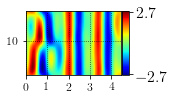

In [6]:
orbit.plot()

In [2]:
%%timeit
# Convert state information to field inplace; derivative operation switches this back to modes?
orbit_field = self.convert(to='field')
# nonlinear = orbit_field.pseudospectral(orbit_field)

nonlinear = 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters), 
                        orbit_field.statemul(orbit_field).convert(to='modes').state), dimension='space')
# orbit_mapping = linear + nonlinear

183 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%%timeit
# Convert state information to field inplace; derivative operation switches this back to modes?
orbit_field = self.convert(to='field')
# nonlinear = orbit_field.pseudospectral(orbit_field)
nonlinear = 0.5*orbit_field.statemul(orbit_field).dx()
# nonlinear = 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters), 
#                         orbit_field.statemul(orbit_field).convert(to='modes').state), dimension='space')
# orbit_mapping = linear + nonlinear

286 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%%timeit
modes = self.convert(to='modes').state
elementwise_dt = self.elementwise_dtn(self.parameters)
elementwise_dx2 = self.elementwise_dxn(self.parameters, power=2)
# elementwise_dx4 = self.elementwise_dxn(self.parameters, power=4)

dt = swap_modes(np.multiply(elementwise_dt, modes), dimension='time')
dx2 = np.multiply(elementwise_dx2, modes)
dx4 = np.multiply(elementwise_dx2, dx2)
linear = dt + dx2 + dx4

# Convert state information to field inplace; derivative operation switches this back to modes?
orbit_field = self.convert(to='field')
# nonlinear = orbit_field.pseudospectral(orbit_field)

nonlinear = 0.5 * swap_modes(np.multiply(self.elementwise_dxn(self.parameters), 
                        orbit_field.statemul(orbit_field).convert(to='modes').state), dimension='space')
orbit_mapping = linear + nonlinear

201 µs ± 915 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
%%timeit 
wj_matrix = self.elementwise_dtn(self.parameters, power=1)
elementwise_qk2 = self.elementwise_dxn(self.parameters, power=2)
elementwise_qk4 = self.elementwise_dxn(self.parameters, power=4)
dt = swap_modes(np.multiply(wj_matrix, other.state), dimension='time')
d2x = np.multiply(elementwise_qk2, other.state)
d4x = np.multiply(elementwise_qk4, other.state)
linear = -1.0*dt + d2x + d4x

22.4 µs ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
%timeit orbit.convert(to='modes').state_type

454 ns ± 1.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
%timeit assert orbit.state_type == 'modes'

60.6 ns ± 0.587 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [11]:
%%timeit
spacetime_modes = self.convert(to='modes').state

# Elementwise multiplication of modes with frequencies, this is the derivative.
dxn_modes = np.multiply(self.elementwise_dxn(self.parameters, power=power), spacetime_modes)

# If the order of the differentiation is odd, need to swap imaginary and real components.
if np.mod(power, 2):
    dxn_modes = swap_modes(dxn_modes, dimension='space')

13.1 µs ± 79.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%%timeit    
spacetime_modes = self.convert(to='modes').state

# Elementwise multiplication of modes with frequencies, this is the derivative.
dxn_modes = np.multiply(self.elementwise_dxn(self.parameters, power=power), spacetime_modes)

# If the order of the differentiation is odd, need to swap imaginary and real components.
if np.mod(power, 2):
    dxn_modes = swap_modes(dxn_modes, dimension='space')
orbit_dxn = self.__class__(state=dxn_modes, state_type='modes', T=self.T, L=self.L, S=self.S)

16.7 µs ± 88.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [4]:
%%timeit
linear = -1.0*other.dt() + other.dx(power=2) + other.dx(power=4)

52.4 µs ± 279 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%%timeit
linear = -1.0*other.dt_modes() + other.dx_modes(power=2) + other.dx_modes(power=4)

30.2 µs ± 297 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
%timeit orbit.elementwise_dxn(orbit.parameters, power=4)

865 ns ± 4.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [3]:
linear = -1.0*other.dt() + other.dx(power=2) + other.dx(power=4)

# Nonlinear component, equal to -u * v_x
orbit_field = self.convert(to='field')
nonlinear = orbit_field.rpseudospectral(other)
orbit_rmatvec = linear + nonlinear


# Derivative with respect to T term equal to DF/DT * v
dfdt = (-1.0 / self.T)*self.dt()
orbit_rmatvec.T = dfdt.dot(other)


# Derivative with respect to L equal to DF/DL * v
dfdl_linear = ((-2.0/self.L)*self.dx(power=2) + (-4.0/self.L)*self.dx(power=4))
dfdl_nonlinear = (-1.0/self.L) * orbit_field.pseudospectral(orbit_field)
dfdl = dfdl_linear + dfdl_nonlinear
orbit_rmatvec.L = dfdl.dot(other)


# Apply left preconditioning
p_matrix = 1.0 / (np.abs(self.elementwise_dtn(self.parameters))
                  + np.abs(self.elementwise_dxn(self.parameters, power=2))
                  + np.abs(self.elementwise_dxn(self.parameters, power=4)))
orbit_rmatvec.state = np.multiply(orbit_rmatvec.state, p_matrix)

orbit_rmatvec.T = orbit_rmatvec.T / self.T
orbit_rmatvec.L = orbit_rmatvec.L/(self.L**4)


In [4]:
t0 = time.time()
for x in range(1000):
    orbit.rmatvec(orbit.spatiotemporal_mapping())
totalt = time.time()-t0
print(totalt/1000.)

0.0011929008960723877


In [5]:
np.linalg.norm(p_matrix)

28.780369341230333

In [6]:
orbit_rmatvec.norm(), linear.norm(), nonlinear.norm(), orbit_rmatvec.T, orbit_rmatvec.L, orbit_rmatvec.S

(0.08876794896091472,
 0.0862369537515598,
 0.0746481456886593,
 -6.4487508377663245e-06,
 1.9964930005251016e-07,
 0.0)

In [7]:
orbit.rmatvec(orbit.spatiotemporal_mapping()).norm()

0.08876794896091472

In [8]:
# the original without caching. 
%timeit orbit.spatiotemporal_mapping()

411 µs ± 3.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
# the original without caching. 
%timeit orbit.rmatvec(orbit.spatiotemporal_mapping())

1.26 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit orbit.dx(power=2) + orbit.dx(power=4)

24.3 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit orbit.dx(power=2) + orbit.dx(power=2).dx(power=2)

30.3 µs ± 159 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
t0=time.time()
result = converge(orbit, method='adj', atol=10**-6, verbose=True)
t1=time.time()
print('adj desc time', t1-t0, 'per step', (t1-t0) / (16384.))

Starting adj numerical method. Initial residual 0.0005996690956943496
........................Current residual 9.62781539937062e-06
........................Current residual 7.111322261412871e-06
........................Current residual 6.280460316994489e-06
........................Current residual 5.881058263289789e-06
........................Current residual 5.621015125082616e-06
........................Current residual 5.415734110640963e-06
.............
Failed to converge. Maximum number of iterations reached. exiting with residual 5.314735732098758e-06
adj desc time 29.445802688598633 per step 0.0017972291680052876


In [13]:
%timeit (-2.0/self.L)*self.dx(power=2)

14.8 µs ± 87.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
%%timeit 
tmp = self.dx(power=2)
tmp.state *= -2.0/self.L

13.1 µs ± 13.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
# the original without caching. 
%%timeit 
orbit.elementwise_dxn(power=2)

In [5]:
%timeit orbit.spatiotemporal_mapping()

563 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit orbit.dx(power=2) + orbit.dx(power=4)

22.2 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%timeit orbit.dx(power=2) + orbit.dx(power=2).dx(power=2)

30.9 µs ± 283 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
orbit1, orbit2 = orbit.copy(), orbit.copy()

In [16]:
orbit1.state

array([[ 1.82701893e+00,  2.66896813e+00,  2.84672811e+00,
         4.54719865e+00, -1.32865659e+00, -3.37103121e+00,
        -1.67110905e+00,  1.22077502e+00, -1.10552280e+00,
        -1.43114686e+01,  4.54719865e+00,  2.64286228e-01,
         8.13838926e+00, -2.50099144e+00],
       [-2.72598575e-01,  8.02991397e-01,  1.59298279e+00,
         9.17621853e-01, -1.72389052e-01, -4.96789766e-01,
        -4.52217497e-01,  4.07972599e-01,  1.93859272e+00,
         3.16863978e-01, -9.17621853e-01, -8.66658288e-01,
        -2.05777059e-01,  3.02162071e-01],
       [ 2.99007168e-01,  4.82054834e-01,  1.24146766e-01,
        -1.40785808e-01,  4.35438090e-01,  1.61978501e-01,
        -1.03895940e-01,  1.99790202e-01, -1.99673650e-01,
        -6.24127941e-01, -1.40785808e-01, -8.66140214e-02,
        -3.91050694e-01, -1.55491263e-01],
       [-4.03433560e-02,  7.26581839e-02,  2.75460967e-01,
         2.14412710e-01, -3.95738018e-02, -5.43022380e-03,
         3.93155865e-02,  6.03780991e-02,  1.

In [17]:
%%timeit 
orbit1.state += orbit2.state
orbit1.state -= orbit2.state

5.16 µs ± 67.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
orbit1 = orbit.copy()


In [26]:

%%timeit 
orbit3 = orbit1 + orbit2
orbit3 = orbit3 - orbit2

8.45 µs ± 97.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit orbit1.state+orbit2.state

1.35 µs ± 8.74 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
%timeit OrbitKS(state=orbit1.state, state_type=orbit1.state_type, T=orbit1.T, L=orbit1.L) 

4.42 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
%timeit orbit1+orbit2

4.86 µs ± 35.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [4]:
parameter_constraints = (False,False,False)
A = orbit.jacobian(parameter_constraints=parameter_constraints)
b = -1.0 * orbit.spatiotemporal_mapping().state.ravel()
correction_tuple = lstsq(A, b.reshape(-1, 1))
correction_vector = correction_tuple[0]
dorbit = _state_vector_to_orbit(orbit, correction_vector, parameter_constraints=parameter_constraints)
next_orbit = orbit.increment(dorbit, stepsize=1)
next_residual = next_orbit.residual()

dorbit.to_h5('ShiftReflectionOrbitKS_new_dx.h5')
next_orbit.to_h5('ShiftReflectionOrbitKS_new_next_orbit.h5')

In [16]:
reqva_test = read_h5('reqva_L27p39.h5', directory='data')
rpo_test = reqva_test.copy()

In [19]:
rpo_test.convert(to='modes').state

array([[ 2.00816119e+00,  1.01374031e+01,  1.11253909e+01,
        -1.40353747e+00,  2.47945593e+00, -4.92810282e+00,
        -2.38748576e-01, -1.12657698e+00,  3.57569991e-01,
        -6.96102814e-02,  1.76386189e-01, -8.29370045e-03,
         2.40090406e-02, -1.05550170e-02,  1.85951257e-05,
        -1.06120071e+01,  7.93479330e+00, -1.19937633e+01,
        -1.74281001e+00, -8.81762255e+00,  8.85404094e-01,
        -6.38238431e-01,  9.23568861e-01,  2.64677768e-01,
         1.64914168e-01,  1.22727752e-02, -2.51199462e-02,
        -1.18906760e-02, -1.08448457e-02,  1.87626015e-03],
       [ 2.12374323e-07, -6.77159230e-09, -1.05227738e-07,
         1.04321013e-07,  6.52678136e-08,  7.85444976e-08,
        -1.35071526e-08,  1.50644277e-08, -2.41765619e-08,
         4.39556843e-09, -7.62882139e-09,  3.81752699e-09,
        -1.76076670e-09,  1.25002985e-09, -3.53632751e-10,
         2.82497007e-08, -4.47835335e-09,  1.20880617e-07,
         1.36970290e-07, -2.24451893e-08, -2.01766804e-

In [6]:
next_orbit.state_type

'modes'

In [7]:
dorbit.state_type

'modes'

In [8]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
# from scipy.fft import irfft,rfft,rfftn,irfftn,fftn,ifftn,fft,ifft,fft2,rfft2
import itertools
from math import pi
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
%matplotlib inline

In [9]:
# To avoid redundant function calls, store optimization variables using
# clunky notation.
next_orbit = orbit.increment(dorbit, stepsize=1)
next_residual = next_orbit.residual()
next_residual

dorbit.to_h5('ShiftReflectionOrbitKS_new_dx.h5')
next_orbit.to_h5('ShiftReflectionOrbitKS_new_next_orbit.h5')

In [10]:
dorbit.state_type

'modes'

In [11]:
dorbit.convert(to='field').state.shape

(64, 32)

In [12]:
dorbit.state.shape

(63, 15)

In [13]:
next_orbit.state.shape

(63, 15)

In [14]:
dorbit_new = read_h5('ShiftReflectionOrbitKS_new_dx.h5')
norbit_new =  read_h5('ShiftReflectionOrbitKS_new_next_orbit.h5')

In [15]:
dorbit_new.state.shape

(64, 32)

In [16]:
dorbit.L, dorbit.T

np.diag(dorbit.state)

next_orbit.L, next_orbit.T

np.diag(next_orbit.state)

array([ 2.38527366e+00,  2.12797768e-01,  5.47833998e+00, -1.38041344e+00,
        1.10630379e-01, -4.24506919e-01, -1.84223759e-03, -2.66330978e-02,
       -1.42215360e-02, -1.32350216e-02,  4.47684091e-03, -5.01678855e-04,
        2.91189870e-04,  8.37055394e-05, -6.42482685e-05])

# Old code version

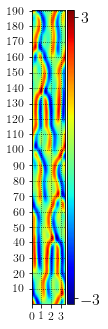

Starting lstsq numerical method. Initial residual 0.0019471593337781078
0
Converged. exiting with residual 3.7852378724652415e-18


TypeError: jacobian() got an unexpected keyword argument 'fixedparams'

In [17]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbit-tmp\\")
from orbithunter import *
import numpy as np
# from scipy.fft import irfft,rfft,rfftn,irfftn,fftn,ifftn,fft,ifft,fft2,rfft2
import itertools
from math import pi
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
%matplotlib inline

orbit = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\ppo_L21p74_T95p23.h5")
orbit.plot(fundamental_domain=False)
orbit.residual()
converge(orbit, method='lstsq', atol=10**-14, verbose=True)

# np.linalg.norm(orbit.spacetime_ifft().spacetime_fft().state - orbit.state)
# np.sum(np.abs(np.dot(orbit.jacobian()[:, :-2], orbit.spatiotemporal_mapping().state.ravel())))
# np.dot(orbit.jacobian()[:, :-2], orbit.spatiotemporal_mapping().state.ravel())

from scipy.linalg import lstsq

def _state_vector_to_orbit(orbit, correction_vector, parameter_constraints=(False,False,False), **kwargs):
    """
    :param orbit:
    :param correction_vector:
    :param preconditioning:
    :param parameter_constraints:
    :param kwargs:
    :return:
    """
    correction_vector = correction_vector.reshape(-1, 1)
    mode_shape, mode_size = orbit.state.shape, orbit.state.size
    d_modes = correction_vector[:mode_size]
    # slice the changes to parameters from vector
    d_params = correction_vector[mode_size:].ravel()

    for i, constrained in enumerate(parameter_constraints):
        if constrained or (i == len(d_params)):
            d_params = np.insert(d_params, i, 0)
    dT, dL, dS = d_params
    correction_orbit = orbit.__class__(state=np.reshape(d_modes, mode_shape), state_type='modes',
                                       T=dT, L=dL, S=dS)
    return correction_orbit

parameter_constraints = (False,False,False)
A = orbit.jacobian(fixedparams=parameter_constraints)
b = -1.0 * orbit.spatiotemporal_mapping().state.ravel()
correction_tuple = lstsq(A, b.reshape(-1, 1))
correction_vector = correction_tuple[0]

dorbit = _state_vector_to_orbit(orbit, correction_vector, fixedparams=parameter_constraints)

# To avoid redundant function calls, store optimization variables using
# clunky notation.
next_orbit = orbit.increment(dorbit, stepsize=1)
next_residual = next_orbit.residual()
next_residual

dorbit.state.shape

dorbit.to_h5('ShiftReflectionOrbitKS_old_dx.h5')
next_orbit.to_h5('ShiftReflectionOrbitKS_old_next_orbit.h5')

# Comparison, new vs. old

In [ ]:
dorbit_new = read_h5('ShiftReflectionOrbitKS_new_dx.h5')
norbit_new =  read_h5('ShiftReflectionOrbitKS_new_next_orbit.h5')
dorbit_old = read_h5('ShiftReflectionOrbitKS_old_dx.h5')
norbit_old = read_h5('ShiftReflectionOrbitKS_old_next_orbit.h5')

In [ ]:
norbit_new.state - norbit_old.state

In [ ]:
(dorbit_new - dorbit_old).state

In [ ]:
dorbit_new.state.shape

In [ ]:
dorbit_new.state-dorbit_old.state

In [ ]:
dorbit.L, dorbit.T

In [ ]:
np.diag(dorbit.state)

In [ ]:
array([-6.65791718e-07, -1.22764484e-06,  3.02886506e-06,  8.73111593e-07,
       -4.13432925e-07, -3.69807476e-07,  1.87536145e-07, -6.51217693e-09,
       -8.35425775e-08,  6.90374691e-07, -4.07607753e-07,  3.98578887e-06,
       -6.97394773e-06,  1.85185123e-05, -3.51514999e-05])

In [ ]:
next_orbit.L, next_orbit.T

In [ ]:
np.diag(next_orbit.state)

In [ ]:
dft_mat = rfft(np.eye(32), norm='ortho', axis=0)
time_dft_mat = np.concatenate((dft_mat[:-1, :].real,
                               dft_mat[1:-1, :].imag), axis=0)
ab_time_dft_mat = np.insert(time_dft_mat,
                            np.arange(time_dft_mat.shape[1]),
                            np.zeros([time_dft_mat.shape[0], time_dft_mat.shape[1]]),
                            axis=1)

In [ ]:
from functools import lru_cache

rpo_test = reqva_test.copy()
class Test:
    @lru_cache(maxsize=None)
    def cached_borrow(self):
        return rpo_test.elementwise_dx()
    
    @classmethod
    @lru_cache(maxsize=None)
    def class_cached_borrow(self):
        return rpo_test.elementwise_dx()
    
    def borrow(self):
        return rpo_test.elementwise_dx()
    
class Test2:
    def borrow(self):
        return rpo_test.elementwise_dx()

# Caching

In [ ]:
%timeit Test().borrow()

In [ ]:
instantiated_test_class = Test()
%timeit instantiated_test_class.borrow()

In [ ]:
%timeit Test().borrow()

In [ ]:
%timeit Test().cached_borrow()

In [ ]:
%timeit Test().class_cached_borrow()

In [ ]:
t = Test()
%timeit -r 100 t.cached_borrow()

In [ ]:
t = Test()
%timeit -r 100 t.class_cached_borrow()

In [ ]:
instantiated_test_class = Test()
%timeit instantiated_test_class.cached_borrow()

In [ ]:
%timeit Test().class_cached_borrow()

In [ ]:
%timeit Test.class_cached_borrow()

In [ ]:
instantiated_test_class = Test()
%timeit instantiated_test_class.class_cached_borrow()

In [ ]:
%timeit Test.class_cached_borrow()

In [ ]:
%timeit Test2().borrow()

In [ ]:
instantiated_test_class = Test()

In [ ]:
%timeit instantiated_test_class.cached_borrow()

In [ ]:
%timeit Test().cached_borrow()

# Caching with class methods.

Testing cases for class method caching. Classmethod on both method in test and method in parent class. 

Return elementwise_dx() by passing arguments, i.e. without instantiation. 


See if calling the class method once and then timing it with another class member works.

See if calling the classmethod, which instantiates a new class instance can be shared. 

In [ ]:
class TestOrbit():
    @classmethod
    @lru_cache(maxsize=None)
    def elementwise_dx(self, L, N, M, m):
        qk = ((2 * pi * self.M / self.L) * np.fft.fftfreq(self.M)[1:self.m+1]).reshape(1, -1)
        qk_vec = np.concatenate((qk, -qk), axis=1)
        return np.tile(qk_vec, (self.N-1, 1))

In [ ]:
class CacheTestOrbit():
    
    @classmethod
    @lru_cache(maxsize=None)
    def cached_function_call(self, L, N, M, m):
        qk = ((2 * pi * M / L) * np.fft.fftfreq(M)[1:m+1]).reshape(1, -1)
        qk_vec = np.concatenate((qk, -qk), axis=1)
        return np.tile(qk_vec, (N-1, 1)) 
    
    @classmethod
    @lru_cache(maxsize=None)
    def cached_function_call(self, L, N, M, m):
        qk = ((2 * pi * M / L) * np.fft.fftfreq(M)[1:m+1]).reshape(1, -1)
        qk_vec = np.concatenate((qk, -qk), axis=1)
        return np.tile(qk_vec, (N-1, 1)) 
    
    @classmethod
    @lru_cache(maxsize=None)
    def cached_elementwise_with_instantiation(self, orbit):
        return RelativeOrbitKS(state=orbit.state,state_type=orbit.state_type, L=orbit.L,
                               N=orbit.N, M=orbit.M, m=orbit.m).elementwise_dx()
        
    @classmethod
    @lru_cache(maxsize=None)
    def cached_elementwise_without_instantiation(self, orbit):
        return orbit.elementwise_dx()

First test the caching by calling an instantiated instance, then class generator, then different class instance. 

In [ ]:
(L, N, M, m) = rpo_test.L, rpo_test.N, rpo_test.M, rpo_test.m

In [ ]:
c = CacheTestOrbit()
%timeit c.cached_elementwise_without_instantiation(L,N,M,m)

In [ ]:
%%timeit CacheTestOrbit().cached_elementwise_without_instantiation(rpo_test)
orbit
rpo_test

In [ ]:
c = CacheTestOrbit()
%timeit c.cached_elementwise_without_instantiation(rpo_test)

In [ ]:
# orbit = rpo_test
c = CacheTestOrbit()
%timeit c.cached_elementwise_with_instantiation(rpo_test)

In [ ]:
%timeit CacheTestOrbit.cached_elementwise_without_instantiation(rpo_test)

In [ ]:
# orbit = rpo_test
%timeit CacheTestOrbit.cached_elementwise_with_instantiation(rpo_test)

In [ ]:
orbit = rpo_test
c = CacheTestOrbit()
%timeit c.cached_elementwise_with_instantiation(orbit)

In [ ]:
orbit = rpo_test
%timeit CacheTestOrbit.cached_elementwise_with_instantiation(orbit)

In [ ]:
orbit = rpo_test
%timeit = CacheTestOrbit().cached_elementwise_with_instantiation(RelativeOrbitKS(state=orbit.state,state_type=orbit.state_type, L=orbit.L,
                               N=orbit.N, M=orbit.M, m=orbit.m))

In [ ]:
orbit = rpo_test

In [ ]:
    @classmethod
    @lru_cache(maxsize=None)
    def wave_vector(self, orbit):
        return  super().wave_vector()
    

In [ ]:
np.linalg.norm(np.ravel(self.elementwise_dx()))

# Actual orbit caching.

Note, do not want to cache the actual jacobian, mapping, rmatvec functions because this will emulate the adjoint descent process, for instance. Only want to see the effect of caching elementwise and frequency vector functions. Want to also check performance of clean vs. current coding implementations for those functions. 

Classmethod is ok, but because caching happens with respect to immutable types, need to pass parameters instead of class instances. The classmethod does not have knowledge of an instance's attributes, even if called as instance.classmethod(). need to pass it immutable 

# need to check
whether or not caching an classmethod that doesn't take arguments will return the same value even if the computation would be different. 


Why am I trying to do class methods instead of functions?

In [8]:
#     @classmethod
#     @lru_cache(maxsize=None)
#     def cached_function_call(orbit, L, N, M, m):
#         qk = ((2 * pi * M / L) * np.fft.fftfreq(M)[1:m+1]).reshape(1, -1)
#         qk_vec = np.concatenate((qk, -qk), axis=1)
#         return np.tile(qk_vec, (N-1, 1)) 
    
#     @classmethod
#     @lru_cache(maxsize=None)
#     def cached_elementwise_with_instantiation(orbit, orbit):
#         return RelativeOrbitKS(state=orbit.state,state_type=orbit.state_type, L=orbit.L,
#                                N=orbit.N, M=orbit.M, m=orbit.m).elementwise_dx()
 

RelativeOrbitKS()

First, test that the classmethod caching does anything to the original code, then compare with "cleaned up" versions. 

In [64]:
from functools import lru_cache
class CachedOrbitKS(OrbitKS):

    def __init__(self, state=None, state_type='modes', T=0., L=0., S=0.):
        super().__init__( state=None, state_type='modes', T=0., L=0., S=0.)
        
    def dt(self, power=1):
        """ A time derivative of the current state.

        Parameters
        ----------
        power :int
            The order of the derivative.

        Returns
        ----------
        orbit_dtn : OrbitKS or subclass instance
            The class instance whose state is the time derivative in
            the spatiotemporal mode basis.
        """
        spacetime_modes = self.convert(to='modes').state
        
        # Elementwise multiplication of modes with frequencies, this is the derivative.
        dtn_modes = np.multiply(self.elementwise_dtn(self, power=power), spacetime_modes)
        
        # If the order of the derivative is odd, then imaginary component and real components switch.
        if np.mod(order, 2):
            dtn_modes = swap_modes(dtn_modes, dimension='time')

        orbit_dtn = self.__class__(state=dtn_modes, state_type='modes', T=self.T, L=self.L, S=self.S)
        return orbit_dtn

    def dx(self, power=1):
        """ A spatial derivative of the current state.

        Parameters
        ----------
        power :int
            The order of the derivative.

        Returns
        ----------
        orbit_dxn : OrbitKS or subclass instance
            Class instance whose spatiotemporal state represents the spatial derivative in the
            the basis of the original state.

        Notes
        -----
        Dimensions provided to np.tile in defining elementwise_dxn were originally (self.N-1, 1).
        """
        spacetime_modes = self.convert(to='modes').state

        # Elementwise multiplication of modes with frequencies, this is the derivative.
        dxn_modes = np.multiply(self.elementwise_dxn(self, power=power), spacetime_modes)

        # If the order of the differentiation is odd, need to swap imaginary and real components.
        if np.mod(order, 2):
            dxn_modes = swap_modes(dxn_modes, dimension='space')
        orbit_dxn = self.__class__(state=dxn_modes, state_type='modes', T=self.T, L=self.L, S=self.S)
        return orbit_dxn.convert(to=self.state_type)
    
    
    @classmethod
    @lru_cache()
    def wave_vector(cls, orbit):
        """ Spatial frequency vector for the current state

        Returns
        -------
        ndarray :
            Array of spatial frequencies of shape (m, 1)
        """
        return ((2 * pi * orbit.M / orbit.L) * np.fft.fftfreq(orbit.M)[1:orbit.m+1]).reshape(1, -1)

    @classmethod
    @lru_cache()
    def frequency_vector(cls, orbit):
        """
        Returns
        -------
        ndarray
            Temporal frequency array of shape {n, 1}

        Notes
        -----
        Extra factor of '-1' because of how the state is ordered; see __init__ for
        more details.

        """
        return (-1.0 * (2 * pi * orbit.N / orbit.T) * np.fft.fftfreq(orbit.N)[1:orbit.n+1]).reshape(-1, 1)

    @classmethod
    @lru_cache()
    def elementwise_dxn(cls, orbit, power=1):
        """ Matrix of temporal mode frequencies

        Creates and returns a matrix whose elements
        are the properly ordered spatial frequencies,
        which is the same shape as the spatiotemporal
        Fourier mode state. The elementwise product
        with a set of spatiotemporal Fourier modes
        is equivalent to taking a spatial derivative.

        Returns
        ----------
        matrix
            Matrix of spatial frequencies
        """
        qkn = orbit.wave_vector(orbit)**order
        # Coefficients which depend on the order of the derivative, see SO(2) generator of rotations for reference.
        c1, c2 = so2_coefficients(power=power)
        # Create elementwise spatial frequency matrix
        dxn_multipliers = np.tile(np.concatenate((c1*qkn, c2*qkn), axis=1), (spacetime_modes.shape[0], 1))
        return dxn_multipliers

    @classmethod
    @lru_cache()
    def elementwise_dtn(cls, orbit, power=1):
        """ Matrix of temporal mode frequencies

        Creates and returns a matrix whose elements
        are the properly ordered temporal frequencies,
        which is the same shape as the spatiotemporal
        Fourier mode state. The elementwise product
        with a set of spatiotemporal Fourier modes
        is equivalent to taking a time derivative.


        Returns
        ----------
        matrix
            Matrix of temporal frequencies
        """
        
        wj = orbit.frequency_vector()
        # Coefficients which depend on the order of the derivative, see SO(2) generator of rotations for reference.
        c1, c2 = so2_coefficients(power=power)
        # The Nyquist frequency is never included, this is how time frequency modes are ordered.
        wjn_vec = np.concatenate(([[0]], c1*wj**order, c2*wj**order), axis=0)
        # Elementwise product of modes with time frequencies is the spectral derivative.
        dtn_multipliers = np.tile(wjn_vec, (1, orbit.state.shape[1]))
        return dtn_multipliers

# ORIGINAL VERSION

    def rmatvec(self, other, parameter_constraints=(False, False), preconditioning=True):
        """ Matrix-vector product with the adjoint of the Jacobian

        Parameters
        ----------
        other : OrbitKS
            OrbitKS whose state represents the vector in the matrix-vector product.
        parameter_constraints : (bool, bool)
            Whether or not period T or spatial period L are fixed.
        preconditioning : bool
            Whether or not to apply (left) preconditioning to the adjoint matrix vector product.

        Returns
        -------
        orbit_rmatvec :
            OrbitKS with values representative of the adjoint-vector product A^H * x.

        """

        # Linear component of the product, equal to -v_t + v_xx + v_xxxx
        wj_matrix = self.elementwise_dtn(self)
        qk_matrix = self.elementwise_dxn(self)
        elementwise_qk2 = -1.0*qk_matrix**2
        elementwise_qk4 = qk_matrix**4

        dt = swap_modes(np.multiply(wj_matrix, other.state), dimension='time')
        d2x = np.multiply(elementwise_qk2, other.state)
        d4x = np.multiply(elementwise_qk4, other.state)
        linear = -1.0*dt + d2x + d4x

        # Nonlinear component, equal to -u * v_x
        orbit_field = self.convert(to='field')
        nonlinear = orbit_field.rpseudospectral(other).state
        orbit_rmatvec = self.__class__(state=(linear + nonlinear))

        if not parameter_constraints[0]:
            # Derivative with respect to T term equal to DF/DT * v
            dt_self = swap_modes(np.multiply(wj_matrix, self.state), dimension='time')
            dfdt = (-1.0 / self.T)*dt_self
            orbit_rmatvec.T = np.dot(dfdt.ravel(), other.state.ravel())

        if not parameter_constraints[1]:
            # Derivative with respect to L equal to DF/DL * v
            d2x_self = np.multiply(elementwise_qk2, self.state)
            d4x_self = np.multiply(elementwise_qk4, self.state)
            dfdl_linear = ((-2.0/self.L)*d2x_self + (-4.0/self.L)*d4x_self)
            dfdl_nonlinear = (-1.0/self.L) * orbit_field.pseudospectral(orbit_field).state
            dfdl = dfdl_linear + dfdl_nonlinear
            orbit_rmatvec.L = np.dot(dfdl.ravel(), other.state.ravel())

        if preconditioning:
            # Apply left preconditioning
            p_matrix = 1.0 / (np.abs(wj_matrix) + qk_matrix**2 + qk_matrix**4)
            orbit_rmatvec.state = np.multiply(orbit_rmatvec.state, p_matrix)

            if not parameter_constraints[0]:
                orbit_rmatvec.T = orbit_rmatvec.T / self.T
            if not parameter_constraints[1]:
                orbit_rmatvec.L = orbit_rmatvec.L/(self.L**4)

        return orbit_rmatvec
    
    def spatiotemporal_mapping(self):
        """ The Kuramoto-Sivashinsky equation evaluated at the current state.

        Returns
        -------
        OrbitKS :
            OrbitKS whose state is representative of the equation u_t + u_xx + u_xxxx + 1/2 (u^2)_x
        :return:
        """
        # For specific computation of the linear component instead
        # of arbitrary derivatives we can optimize the calculation by being specific.

        wj_matrix = self.elementwise_dtn(self)
        qk_matrix = self.elementwise_dxn(self)
        elementwise_d2xd4x = -1.0*qk_matrix**2 + qk_matrix**4
        ut = swap_modes(np.multiply(wj_matrix, self.state), dimension='time')
        u2x_u4x = np.multiply(elementwise_d2xd4x, self.state)
        linear = ut + u2x_u4x
        # Convert state information to field inplace; derivative operation switches this back to modes?
        orbit_field = self.convert(to='field')
        nonlinear = orbit_field.pseudospectral(orbit_field).state
        orbit_mapping = self.__class__(state=(linear + nonlinear),
                                       T=self.T, L=self.L, S=self.S)

        return orbit_mapping
    
# CLEAN VERSIONS    

    def rmatvec(self, other, parameter_constraints=(False, False), preconditioning=True):
        """ Matrix-vector product with the adjoint of the Jacobian

        Parameters
        ----------
        other : OrbitKS
            OrbitKS whose state represents the vector in the matrix-vector product.
        parameter_constraints : (bool, bool)
            Whether or not period T or spatial period L are fixed.
        preconditioning : bool
            Whether or not to apply (left) preconditioning to the adjoint matrix vector product.

        Returns
        -------
        orbit_rmatvec :
            OrbitKS with values representative of the adjoint-vector product A^H * x.

        """

        dt = swap_modes(np.multiply(wj_matrix, other.state), dimension='time')
        d2x = np.multiply(elementwise_qk2, other.state)
        d4x = np.multiply(elementwise_qk4, other.state)
        linear = -1.0*self.dt() + d2x + d4x

        # Nonlinear component, equal to -u * v_x
        orbit_field = self.convert(to='field')
        nonlinear = orbit_field.rpseudospectral(other).state
        orbit_rmatvec = self.__class__(state=(linear + nonlinear))

        if not parameter_constraints[0]:
            # Derivative with respect to T term equal to DF/DT * v
            dt_self = swap_modes(np.multiply(wj_matrix, self.state), dimension='time')
            dfdt = (-1.0 / self.T)*dt_self
            orbit_rmatvec.T = np.dot(dfdt.ravel(), other.state.ravel())

        if not parameter_constraints[1]:
            # Derivative with respect to L equal to DF/DL * v
            d2x_self = np.multiply(elementwise_qk2, self.state)
            d4x_self = np.multiply(elementwise_qk4, self.state)
            dfdl_linear = ((-2.0/self.L)*d2x_self + (-4.0/self.L)*d4x_self)
            dfdl_nonlinear = (-1.0/self.L) * orbit_field.pseudospectral(orbit_field).state
            dfdl = dfdl_linear + dfdl_nonlinear
            orbit_rmatvec.L = np.dot(dfdl.ravel(), other.state.ravel())

        if preconditioning:
            # Apply left preconditioning
            p_matrix = 1.0 / (np.abs(wj_matrix) + qk_matrix**2 + qk_matrix**4)
            orbit_rmatvec.state = np.multiply(orbit_rmatvec.state, p_matrix)

            if not parameter_constraints[0]:
                orbit_rmatvec.T = orbit_rmatvec.T / self.T
            if not parameter_constraints[1]:
                orbit_rmatvec.L = orbit_rmatvec.L/(self.L**4)

        return orbit_rmatvec
    
    def spatiotemporal_mapping(self):
        """ The Kuramoto-Sivashinsky equation evaluated at the current state.

        Returns
        -------
        OrbitKS :
            OrbitKS whose state is representative of the equation u_t + u_xx + u_xxxx + 1/2 (u^2)_x
        :return:
        """
        # For specific computation of the linear component instead
        # of arbitrary derivatives we can optimize the calculation by being specific.

        wj_matrix = self.elementwise_dtn(self)
        qk_matrix = self.elementwise_dxn(self)
        elementwise_d2xd4x = -1.0*qk_matrix**2 + qk_matrix**4
        ut = swap_modes(np.multiply(wj_matrix, self.state), dimension='time')
        u2x_u4x = np.multiply(elementwise_d2xd4x, self.state)
        linear = ut + u2x_u4x
        # Convert state information to field inplace; derivative operation switches this back to modes?
        orbit_field = self.convert(to='field')
        nonlinear = orbit_field.pseudospectral(orbit_field).state
        orbit_mapping = self.__class__(state=(linear + nonlinear),
                                       T=self.T, L=self.L, S=self.S)

        return orbit_mapping

In [68]:
OrbitKS().spatiotemporal_mapping().__repr__

<bound method OrbitKS.__repr__ of OrbitKS()>

In [59]:
test0 = CachedRelativeOrbitKS(state=rpo_test.state, state_type=rpo_test.state_type, L=rpo_test.L, T=rpo_test.T, S=rpo_test.S)

In [60]:
print(test0)

CachedRelativeOrbitKS()


In [63]:
RelativeOrbitKS(state=orbit.state,state_type=orbit.state_type,T=orbit.T, L=orbit.L,N=orbit.N, M=orbit.M, m=orbit.m) == RelativeOrbitKS(state=orbit.state,state_type=orbit.state_type,T=orbit.T, L=orbit.L,N=orbit.N, M=orbit.M, m=orbit.m)

False

In [61]:
%timeit test0.frequency_vector(orbit)

26.1 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
test1 = CachedRelativeOrbitKS(state=next_orbit.state, state_type=next_orbit.state_type, L=next_orbit.L, T=next_orbit.T, S=rpo_test.S)

In [ ]:
test1.frequency_vector()

In [ ]:
test1.mode_shape

In [ ]:
%timeit -r 1 -n 50 test.borrow

In [ ]:
%timeit -r 1 -n 1 test.borrow

In [ ]:
np.sum(time_dft_mat[0]*rpo_test.state[0,:]

In [ ]:
np.linalg.norm([3,4], ord=1)

# ab_time_dft_mat.shape

In [ ]:
time_dft_mat.shape

In [ ]:
ab_time_dft_mat.shape

In [ ]:
os.getcwd()

In [ ]:
reqva_test.residual()
converge(reqva_test, method='lstsq', atol=10**-14, verbose=True)

In [ ]:
reqva_test.plot(fundamental_domain=False)

In [ ]:
spacetime_modes = (1./np.sqrt(32)) * self.state

In [ ]:
np.sum((1./np.sqrt(32)) * np.concatenate((0*np.eye(15), np.eye(15)), axis=1),axis=1)

In [ ]:
dft_mat = rfft(np.eye(32), norm='ortho', axis=0)
time_idft_mat = np.concatenate((dft_mat[:-1, :].real,
                                        dft_mat[1:-1, :].imag), axis=0)
time_idft_mat

In [ ]:
rpo_test = reqva_test.copy()

rpo_test.convert(to='s_modes', inplace=True)
rpo_test.state = np.tile(reqva_test.convert(to='s_modes').state[-1,:].reshape(1,-1),(32,1))
smode0 = rpo_test.state[0,0]
rpo_test.convert(to='modes', inplace=True)

The transformation from s_modes to modes should result in division by np.sqrt(32). So what is going on. 

In [ ]:
rpo_test.state[0,0], smode0

In [ ]:
rpo_test.comoving_mapping_component().change_reference_frame().plot()

In [ ]:
rpo_test.change_reference_frame().comoving_mapping_component().state

In [ ]:
rpo_test.change_reference_frame().plot(fundamental_domain=False)

In [ ]:
rpo_test.change_reference_frame().dt().state

In [ ]:
(1/np.sqrt(32)) * smode0

In [ ]:
dft_mat = rfft(np.eye(32), norm='ortho', axis=0)
time_dft_mat = np.concatenate((dft_mat[:-1, :].real,
                               dft_mat[1:-1, :].imag), axis=0)
ab_time_dft_mat = np.insert(time_dft_mat,
                            np.arange(time_dft_mat.shape[1]),
                            np.zeros([time_dft_mat.shape[0], time_dft_mat.shape[1]]),
                            axis=1)
ab_time_dft_mat.shape

In [ ]:
np.sqrt(32)

In [ ]:
rfft(np.ones(32), norm='ortho')

In [ ]:
reqva_test.convert(to='s_modes').state[-1,0]

In [ ]:
rpo_test.time_transform_matrix()*np.sqrt(32)

In [ ]:
ShiftReflectionOrbitKS()

In [ ]:
# atorus = 
# torus = 
# a = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\anti_L17p5_T17.h5")
# defect0 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L12p87_T26.h5")
o2 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\full_L26.7_T54.h5")
# defect = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L13p02_T15.h5")
sr = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\ppo_L34p09_T23p18.h5")
# e = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\eqva_L3p195.h5")
srtest = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L22p01_T85p99.h5")



In [ ]:
ft = sr.spacetime_fft_matrix()
ift = sr.spacetime_ifft_matrix()

In [ ]:
sr = 1.5 * sr

In [ ]:
converge(sr, method='lstsq', verbose=True)

In [ ]:
# srtest.plot(fundamental_domain=False)

# srtest.S

# srtest.reflection().plot(fundamental_domain=False)

# srtest_refl = srtest.reflection()

# sr_srrefl_state = np.concatenate((srtest_refl.state, srtest.state))

# test_orbit = ShiftReflectionOrbitKS(state=sr_srrefl_state, statetype='field', T=2*srtest.T, L=srtest.L)

# test_orbit.plot(fundamental_domain=False)

In [ ]:
test_orbit.time_transform_matrix().shape

In [ ]:
np.dot(test_orbit.time_transform_matrix(), test_orbit.time_inv_transform_matrix()).shape#.sum(axis=1).sum()

In [ ]:
test_orbit.time_transform_matrix()

In [ ]:
test_orbit_result = converge(test_orbit, method='lstsq', verbose=True)

In [ ]:
o2 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\full_L26.7_T54.h5")
a2 = AntisymmetricOrbit(state=np.roll(o2.state, 6 ,axis=1), statetype=o2.statetype, T=o2.T, L=o2.L)
a2result = converge(a2, verbose=True)
a3 = a2result.orbit.convert(to='field')
o3 = Orbit(state=np.roll(a3.state, 6 ,axis=1), statetype=a3.statetype, T=a3.T, L=a3.L)
o3result = converge(o3, fixedparams=(False, True, False), verbose=True)
o4 = o3result.orbit.convert(to='field')
o4 = Orbit(state=np.roll(o4.state, 6 ,axis=1), statetype=o4.statetype, T=o4.T, L=o4.L)
o4result = converge(o4, fixedparams=(False, True, False), verbose=True)

In [ ]:
a2 = AntisymmetricOrbit(state=np.roll(o2.state, 6 ,axis=1), statetype=o2.statetype, T=o2.T, L=o2.L)

In [ ]:
o3result.orbit.L

In [ ]:
a3.L

In [ ]:
o3result.orbit.L

In [ ]:
a3.L-0.01

In [ ]:
o2.plot(fundamental_domain=False)

In [ ]:
defect.S

In [ ]:
defect.to_fundamental_domain().plot(fundamental_domain=False)

In [ ]:
defect.to_fundamental_domain().calculate_shift()

In [ ]:
defect.plot()

In [ ]:
defect2 = RelativeOrbit(state=defect.state, T=defect.T, L=defect.L, S=-1.0*defect.to_fundamental_domain().calculate_shift())
defect2 = defect2.to_fundamental_domain()

In [ ]:
defect2.S = defect.S+defect2.S

In [ ]:
defect2.S 

In [ ]:
defect2.plot(padding=False, fundamental_domain=False)

In [ ]:
result = converge(defect2, verbose=True)

In [ ]:
result.orbit.S

In [ ]:
result.orbit.plot(fundamental_domain=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(np.tile(result.orbit.state, (32,32)),cmap='jet',aspect='auto')

In [ ]:
defect = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L13p02_T15.h5")

In [ ]:
defect0 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L12p87_T26.h5")
defect0.S *=-1

In [ ]:
defect0.residual()

In [ ]:
defect.S

In [ ]:
defect.plot(fundamental_domain=False)

In [ ]:
exit_code = 1
result = converge(defect2, fixedparams=(False, False, False), verbose=True)
defect_down = result.orbit

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.L -= 0.01
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down, fixedparams=(False, True, False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.orbit
        print(result.orbit.state_vector()[-3:])
        defect_down.plot()
defect_down.plot()

In [ ]:
exit_code = 1
result = converge(defect, fixedparams=(False, False, True), verbose=True)
defect_down = result.orbit

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.S += 2
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down, method='lstsq', fixedparams=(False,False,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.orbit
        print(result.orbit.state_vector()[-3:])
        defect_down.plot(fundamental_domain=False)
defect_down.plot(fundamental_domain=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(np.tile(defect.state, (32,32)),cmap='jet',aspect='auto')

In [ ]:
exit_code = 1
result = converge(defect_down, fixedparams=(False, False, False), verbose=True)
defect_down = result.torus

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.L -= 0.01
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down, method='lstsq', fixedparams=(False,True,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus
        print(result.torus.L)
        defect_down.plot()
defect_down.plot()

In [ ]:
# defect = rediscretize(defect, newN=32, newM=32)#.to_fundamental_domain()
# result = converge(defect, fixedparams=(False, False, False), verbose=True)
# defect = result.torus

In [ ]:
defect.S

In [ ]:
defect.plot()

In [ ]:


defect_down = RelativeTorus(state=defect.convert(to='field').state, statetype='field', T=defect.T, L=defect.L, S=defect.S)
exit_code = 1
result = converge(defect_down, fixedparams=(False, False, False), verbose=True)
defect_down = result.torus

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.L -= 0.01
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down,  fixedparams=(False,True,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus
        defect_down.plot(save=True)
defect_down.plot(save=True)

In [ ]:
defect_up = RelativeTorus(state=defect.convert(to='field').state, statetype='field', T=defect.T, L=defect.L, S=defect.S)
exit_code = 1
result = converge(defect_up, fixedparams=(False, False, False), verbose=True)
defect_up = result.torus

while exit_code == 1:
    defect_up.L += 2
    print(defect_up.L)
    result = converge(defect_up,  fixedparams=(False,False,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_up = result.torus
        print(result.torus.L)
        defect_up.plot()
defect_up.plot()

In [ ]:
result = converge(rediscretize(a, newN=32, newM=32), fixedparams=(False, False, False), verbose=True)
wiggle = result.torus

In [ ]:
wiggle.plot()

In [ ]:
wiggle_up = Torus(state=wiggle.convert(to='field').state, statetype='field', T=wiggle.T, L=wiggle.L)
exit_code = 1

In [ ]:
wiggle_up.N

In [ ]:
niter=0
while exit_code == 1:
    wiggle_up.L += 0.01
    result = converge(wiggle_up, method='lstsq', fixedparams=(False, True, False), verbose=False)
    exit_code = result.exit_code
    
    if exit_code == 1:
        niter+=1
        wiggle_up = result.torus
        print(result.torus.L)
        if niter % 5 == 0:
            wiggle_up.plot()
        # wiggle_freeboundary.plot()
wiggle_up.plot()

In [ ]:
wiggle_up = Torus(state=wiggle.convert(to='field').state, statetype='field', T=wiggle.T, L=wiggle.L)
exit_code = 1

In [ ]:
while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    wiggle_up.L += 0.5
    # print(wiggle_freeboundary.residual())
    result = converge(wiggle_up, verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        wiggle_up = result.torus
        print(result.torus.L)
        wiggle_up.plot()
        
print(result.torus.L)
wiggle_up.plot()

In [ ]:
result = converge(wiggle, fixedparams=(False, True, False), verbose=True)
wiggle = result.torus

In [ ]:
wiggle_freeboundary = RelativeTorus(state=wiggle.state, statetype=wiggle.statetype, T=wiggle.T, L=wiggle.L, S=0)
exit_code = 1

wiggle_freeboundary.S = float(wiggle_freeboundary.calculate_shift())



while exit_code == 1:
    wiggle_freeboundary.L -= 0.01
    result = converge(wiggle_freeboundary, fixedparams=(False, True, False), verbose=True)
    exit_code = result.exit_code
    print(exit_code, result.torus.L)
    if exit_code == 1:
        wiggle_freeboundary = result.torus

In [ ]:
# defect_down = rediscretize(r, newN=32, newM=32)#.to_fundamental_domain()
defect_down = defect
# defect = RelativeTorus(state=wiggle.state, statetype=wiggle.statetype, T=wiggle.T, L=wiggle.L, S=0)
exit_code = 1
# wiggle_freeboundary.S = float(wiggle_freeboundary.calculate_shift())

while exit_code == 1:
    defect_down.L -= 0.1
    result = converge(defect_down, method='lstsq', fixedparams=(False, True, False),  verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus

In [ ]:
defect_up = rediscretize(r, newN=32, newM=32)#.to_fundamental_domain()
# wiggle_freeboundary = RelativeTorus(state=wiggle.state, statetype=wiggle.statetype, T=wiggle.T, L=wiggle.L, S=0)
exit_code = 1
while exit_code == 1:
    defect_down.L += 0.1
    result = converge(defect_down, fixedparams=(False, False, False),  verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus

In [ ]:
result

In [ ]:
result = converge(wiggle_freeboundary, fixedparams=(False, True, False), method='lstsq', verbose=True)


In [ ]:
wiggle_freeboundary.plot(fundamental_domain=False)

In [ ]:
def draw_nodal_lines(orbit, epsilon=0.2):
    orbit_dx_field = orbit.dx().convert(to='field').state
    nodal = np.where(np.abs(orbit_dx_field)< epsilon) 
    not_nodal = np.where(np.abs(orbit_dx_field) >= epsilon)
    orbit_dx_field[nodal]=1
    orbit_dx_field[not_nodal]=None
    
    return orbit_dx_field

In [ ]:
# anew = rediscretize(a, newN=256, newM=256)
# rnew = rediscretize(r, newN=256, newM=256)
# enew = rediscretize(e, newN=256, newM=256)
# anew.plot(fundamental_domain=False, padding=False)
# rnew.comoving_transformation().plot(fundamental_domain=False, padding=False)

In [ ]:
rnode = draw_nodal_lines(rnew.to_fundamental_domain(), epsilon=0.1)
rnode_halfcell = np.roll(rnode, rnode.shape[1]//2, axis=1)

fig = plt.figure()
plt.imshow(rnode, origin='lower')
_ = plt.show()

fig = plt.figure()
plt.imshow(rnode_halfcell, origin='lower')
_ = plt.show()

In [ ]:
wiggle_freeboundary

In [ ]:
anode = draw_nodal_lines(anew, epsilon=0.1)
anode_halfcell = np.roll(anode, anode.shape[1]//2, axis=1)

fig = plt.figure()
plt.imshow(anode, origin='lower')
_ = plt.show()

fig = plt.figure()
plt.imshow(anode_halfcell, origin='lower')
_ = plt.show()

In [ ]:
fig = plt.figure()
plt.imshow(draw_nodal_lines(rediscretize(a, newN=256, newM=256)))
_ = plt.show()

In [ ]:
Torus(state=draw_nodal_lines(a), statetype='field',

In [ ]:
e.convert(to='field').state.shape

In [ ]:
e.convert(to='modes').state.shape

In [ ]:
converge(e)

In [ ]:
e.N

In [ ]:
padding = np.zeros([e.state.shape[0], 32])
eqv_modes = e.convert(to='modes').state
padded_modes = np.concatenate((eqv_modes, padding), axis=1)

In [ ]:
padded_modes.shape

In [ ]:
e.convert(to='modes').state

In [ ]:
e.convert(to='field').state.shape

In [ ]:
e3 = rediscretize(e.convert(to='field'), newN=32, newM=32)

In [ ]:
e3.state.shape

In [ ]:
erd = rediscretize(e.convert(to='field'), newN=a.N+2, newM=a.M+2)

In [ ]:
ard = rediscretize(a.convert(to='field'), newN=a.N+2, newM=a.M+2)

In [ ]:
ord_ = rediscretize(o.convert(to='field'), newN=o.N+2, newM=o.M+2)
ord_ = rediscretize(o.convert(to='field'), newN=o.N-2, newM=o.M-2)

In [ ]:
ord_.plot()

In [ ]:
o2rd = rediscretize(o2.convert(to='field'), newN=o2.N+2, newM=o2.M+2)
o2rd_ = rediscretize(o2.convert(to='field'), newN=o2.N-2, newM=o2.M-2)

In [ ]:
rrd = rediscretize(r.convert(to='field'), newN=r.N+2, newM=r.M+2)
rrd = rediscretize(r.convert(to='field'), newN=r.N-2, newM=r.M-2)

In [ ]:
srrd = rediscretize(sr.convert(to='field'), newN=sr.N+2, newM=sr.M+2)
srrd = rediscretize(sr.convert(to='field'), newN=sr.N-2, newM=sr.M-2)

In [ ]:
erd = rediscretize(e.convert(to='field'), newN=e.N+2, newM=e.M+2)
erd = rediscretize(e.convert(to='field'), newN=e.N-2, newM=e.M-2)

In [ ]:
a_result = converge(ard, verbose=True)
a_result

In [ ]:
a_result.torus.plot()

In [ ]:
o_result = converge(ord_, verbose=True)
o_result

In [ ]:
o_result.torus.plot()

In [ ]:
ord_.mode_shape

In [ ]:
ord_.plot()

In [ ]:
o2_result = converge(o2rd, verbose=True)
o2_result

In [ ]:
o2_result.torus.plot()

In [ ]:
o2_result = converge(o2, atol=10**-14, verbose=True)
o2_result

In [ ]:
o2_result.torus.plot()

In [ ]:
r_result = converge(rrd, verbose=True)
r_result

In [ ]:
r_result.torus.plot()

In [ ]:
sr_result = converge(srrd, verbose=True)
sr_result

In [ ]:
sr_result.torus.plot()

In [ ]:
e.elementwise_dx()

In [ ]:
e.wave_vector().shape

In [ ]:
e.m

In [ ]:
x0 = AntisymmetricOrbit(state=torus.state, statetype=torus.statetype, L=torus.L, T=torus.T)

xfr = converge(x0, method='lstsq')
xf = xfr.orbit

In [ ]:
xf.plot(fundamental_domain=False)
xf.residual()


In [ ]:
# x0 = rediscretize(xf.convert(to='field'), newN=16, newM=32)
x = ShiftReflectionOrbit(state=np.roll(xf.convert(to='field').state,7,axis=1), statetype='field',T=xf.T, L=xf.L) 

x.residual()

x.plot(fundamental_domain=False)

In [ ]:
xf_result = converge(x, atol=10**-14, max_iter=10000, verbose=True)

xf_result.orbit.residual()

xf_result.orbit.state

xf_result = converge(xfa, method='lstsq', atol=10**-14, verbose=True)

ppotorus.plot()

ppotorus.residual()

xf_result = converge(ppotorus, method='lstsq',atol=10**-14, verbose=True)

xf_result.orbit.residual()

xf_result.orbit.plot()

xf_result.orbit.statetype

x0 = xf_result.orbit.convert(to='field')
x = Torus(state=x0.state,statetype='field',T=x0.T, L=x0.L) 

x.plot()

x.residual()

xf_result = converge(x, method='lstsq',atol=10**-14, verbose=True)

xf_result.orbit.plot()

xf = converge(x,method='adj',atol=10**-14, verbose=True)

xff = converge(xf.torus, method='lstsq',atol=10**-14, verbose=True)

xf.torus.residual()

atorus = AntisymmetricOrbit(state=torus.state, statetype='field', T=torus.T, L=torus.L)

ppotorus = ShiftReflectionOrbit(state=torus.state, statetype='field', T=torus.T, L=torus.L)

a_old_vv = atorus.convert(to='modes').state

u = torus.convert(to='field').state

a_old_v = atorus.convert(to='s_modes').state
ppo_old_v = ppotorus.convert(to='s_modes').state
old_v = torus.convert(to='s_modes').state

a_old_vv = atorus.convert(to='modes').state
ppo_old_vv = ppotorus.convert(to='modes').state
old_vv = torus.convert(to='modes').state

In [ ]:
space_modes = rfft(torus.convert(to='field').state, norm='ortho', axis=1)[:, 1:-1]
spatial_modes = np.concatenate((space_modes.real, space_modes.imag), axis=1)

In [ ]:
modes = rfft(spatial_modes, norm='ortho', axis=0)
modes_real = modes.real[:-1, -atorus.m:]
modes_imag = modes.imag[1:-1, -atorus.m:]
anti_spacetime_modes = np.concatenate((modes_real, modes_imag),axis=0)

In [ ]:
# PPO
modes = rfft(spatial_modes, norm='ortho', axis=0)
modes_real = modes.real[:-1, :-torus.m] + modes.real[:-1, -torus.m:]
modes_imag = modes.imag[1:-1, :-torus.m] + modes.imag[1:-1, -torus.m:]
ppo_spacetime_modes = np.concatenate((modes_real, modes_imag),axis=0)

In [ ]:
# Torus, RelativeTorus
modes = rfft(spatial_modes, norm='ortho', axis=0)
modes_real = modes.real[:-1, :] 
modes_imag = modes.imag[1:-1, :]
spacetime_modes = np.concatenate((modes_real, modes_imag),axis=0)

In [ ]:
mat_tmp = irfft(np.eye(torus.N//2+1), norm='ortho', axis=0)
time_irfft_mat = np.concatenate((mat_tmp[:,:-1], mat_tmp[:,1:-1]),axis=1)

In [ ]:
np.linalg.norm(f.transpose()-space_mat)

In [ ]:
self = torus
fx = (1 / np.sqrt(self.M)) * old_rfft(np.eye(self.M), axis=0)[1:self.M - 1, :]
fx_a = np.zeros([self.m, self.M], float)
fx_b = np.zeros([self.m, self.M], float)

indices = np.arange(0, self.m)
fx_a[indices, :] = fx[2 * indices, :]
fx_b[indices, :] = fx[2 * indices + 1, :]

ff = np.concatenate((fx_a, fx_b), axis=0)

In [ ]:
plt.imshow(f-space_mat)
_ = plt.show()

In [ ]:
space_real_mat = irfft(np.eye(torus.M//2 + 1), norm='ortho', axis=0)

space_imag_mat = irfft(1j*np.eye(torus.M//2 + 1), norm='ortho', axis=0)

space_mat = np.concatenate((space_real_mat[:, 1:-1], space_imag_mat[:, 1:-1]),axis=1)

space_ifft_matrix = np.kron(space_mat, np.eye(torus.N))

np.linalg.norm(space_ifft_matrix-torus.space_irfft_matrix())

In [ ]:
space_mat.shape

In [ ]:
np.eye(torus.M//2 + 1).shape

In [ ]:
irfft(np.eye(torus.M//2 + 1), norm='ortho', axis=0)

In [ ]:
fx = np.sqrt(self.M)*old_irfft(np.eye(self.M), axis=0)[:, 1:self.M-1]
fx_a = np.zeros([self.M, self.m], float)
fx_b = np.zeros([self.M, self.m], float)

indices = np.arange(0, self.m)
fx_a[:, indices] = fx[:, 2 * indices]
fx_b[:, indices] = fx[:, 2 * indices + 1]

fb = np.concatenate((fx_a, fx_b), axis=1)

In [ ]:
imag_idft_matrix = irfft(1j*np.eye((torus.N//2)+1), norm='ortho', axis=0)
real_idft_matrix = irfft(np.eye((torus.N//2)+1), norm='ortho', axis=0)
time_idft_matrix = np.concatenate((real_idft_matrix[:, :-1], imag_idft_matrix[:, 1:-1]),axis=1)
ab_time_idft_matrix = np.insert(time_idft_matrix, np.arange(time_idft_matrix.shape[0]), time_dft_matrix, axis=0)

ab_transform_formatter = np.zeros((2*torus.N, torus.N-1),dtype=int)
ab_transform_formatter[::2,1:-torus.n:2] = 1
ab_transform_formatter[1::2,:-torus.n:2] = 1
ab_transform_formatter[1::2,-torus.n+1::2] = 1
ab_transform_formatter[::2,-torus.n::2] = 1

full_time_ifft_matrix = np.kron(ab_time_idft_matrix*ab_transform_formatter, 
                                np.eye(torus.mode_shape[1]))

In [ ]:
ab_transform_formatter = np.zeros((torus.N-1, 2*torus.N),dtype=int)
#odd rows
ab_transform_formatter[1:-torus.n:2,::2] = 1
ab_transform_formatter[:-torus.n:2,1::2] = 1
ab_transform_formatter[-torus.n+1::2,1::2] = 1
ab_transform_formatter[-torus.n::2, ::2] = 1

full_dft_mat = rfft(np.eye(torus.M), norm='ortho', axis=0)
# time_real_mat = rfft(np.eye(torus.N//2+1), norm='ortho', axis=0)
time_dft_mat = np.concatenate((full_dft_mat[:-1, :].real, full_dft_mat[1:-1, :].imag), axis=0)
ab_time_dft_matrix = np.insert(time_dft_mat, np.arange(time_dft_mat.shape[1]), time_dft_mat, axis=1)
full_time_fft_matrix = np.kron(ab_time_dft_matrix*ab_transform_formatter, np.eye(torus.m))

In [ ]:
idft_mat = irfft(np.eye(torus.N//2 + 1), norm='ortho', axis=0)
time_idft_mat = np.concatenate((idft_mat[:, :-1].real, 
                                idft_mat[:, 1:-1].imag), axis=1)

In [ ]:
torus.dt_matrix().shape

In [ ]:
torus.dx_matrix(power=2).shape

In [ ]:
%%timeit
torus.dt_matrix() + torus.dx_matrix(power=2, statetype='modes') + torus.dx_matrix(power=4, statetype='modes')

In [ ]:
%%timeit
qk=torus.wave_vector().ravel()
dx2 = -1*np.kron(np.eye(torus.N-1), np.diag(qk**2))
dx4 = -1*np.kron(np.eye(torus.N-1), np.diag(qk**4))
jl = torus.dt_matrix() + dx2 + dx4

In [ ]:
idft_mat = irfft(np.eye(torus.M//2 + 1), norm='ortho', axis=0)[:, 1:-1]
space_idft_mat = np.concatenate((idft_mat.real, idft_mat.imag), axis=1)
space_idft_mat.shape

In [ ]:
dft_mat = rfft(np.eye(torus.N), norm='ortho', axis=0)
time_dft_mat = np.concatenate((dft_mat[:-1,:].real, dft_mat[1:-1,:].imag), axis=0)
ab_time_dft_mat = np.insert(time_dft_mat, 
                             np.arange(time_dft_mat.shape[1]), 
                             np.zeros([time_dft_mat.shape[0], time_dft_mat.shape[1]]),
                             axis=1)
np.kron(ab_time_dft_mat, np.eye(torus.m)).shape

In [ ]:
plt.imshow(ab_time_idft_mat)
plt.colorbar()
_ = plt.show()

In [ ]:
ab_time_idft_mat.shape

In [ ]:
tttt = full_time_ifft_matrix[full_time_ifft_matrix!=0]
tttt[-5:]

In [ ]:
# tmptmp = time_test[:, np.newaxis, :]


In [ ]:
shuf2 = np.tile(np.insert(np.ones(8), np.arange(8), np.zeros(8)), (32,1))
shuf1 = np.tile(np.insert(np.zeros(8), np.arange(8), np.ones(8)), (32,1))
shuffle_mat = np.insert(shuf1.reshape(32, 1, 16), np.arange(32), shuf2.reshape(32,1,16),axis=0).squeeze()
t2 = np.concatenate((shuffle_mat, shuffle_mat[:,1:]),axis=1)*tst
# shufodd = np.roll(np.insert(shuf1.reshape(16, 1, 32), np.arange(16), shuf2.reshape(16,1,32),axis=0).squeeze(),1,axis=1)
# shufodd = shufodd[:,:-1]
# shufeven = shufeven[:,:-1]

In [ ]:
# %%timeit


In [ ]:
plt.imshow(tst)
plt.colorbar()
_ = plt.show()

In [ ]:
plt.imshow(t2)
plt.colorbar()
_ = plt.show()

In [ ]:
plt.imshow((tst*rangeifft)-t2)
_ = plt.colorbar()

In [ ]:
%%timeit
torus.time_irfft_matrix()

In [ ]:
%%timeit
rangefft = np.zeros((31, 64),dtype=int)
#odd rows
rangefft[1:-15:2,::2] = 1
rangefft[:-15:2,1::2] = 1
rangefft[-15+1::2,1::2] = 1
rangefft[-15::2, ::2] = 1
time_mat = rfft(np.eye(torus.M), norm='ortho', axis=0)
# time_real_mat = rfft(np.eye(torus.N//2+1), norm='ortho', axis=0)
time_forward = np.concatenate((time_mat[:-1, :].real, time_mat[1:-1, :].imag), axis=0)
time_mat_large = np.insert(time_forward, np.arange(time_forward.shape[1]), time_forward, axis=1)*rangefft
full_time_fft_matrix = np.kron(time_mat_large, np.eye(torus.m))
# np.linalg.norm(full_time_ifft_matrix-torus.time_ifft_matrix())

In [ ]:
%%timeit
rangefft = np.zeros((31, 64),dtype=int)
#odd rows
rangefft[1:-15:2,::2] = 1
rangefft[:-15:2,1::2] = 1
rangefft[-15+1::2,1::2] = 1
rangefft[-15::2, ::2] = 1

In [ ]:
%%timeit
shuf22 = np.tile(np.insert(np.ones(32), np.arange(32), np.zeros(32)).reshape(1, -1), (8, 1))
shuf12 = np.tile(np.insert(np.zeros(32), np.arange(32), np.ones(32)).reshape(1, -1), (8, 1))
shuffle_mat2 = np.insert(shuf12, np.arange(8), shuf22, axis=0)
shuf_final = np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0)

time_mat = rfft(np.eye(torus.M), norm='ortho', axis=0)
time_forward = np.concatenate((time_mat[:-1, :].real, time_mat[1:-1, :].imag), axis=0)
time_mat_large = np.insert(time_forward, np.arange(time_forward.shape[1]), time_forward, axis=1)*shuf_final
full_time_fft_matrix = np.kron(time_mat_large, np.eye(torus.m))

In [ ]:
plt.imshow(full_time_ifft_matrix)

In [ ]:
plt.imshow(torus.time_irfft_matrix()-full_time_ifft_matrix)

In [ ]:
rangefft = np.zeros((31, 64),dtype=int)
rangefft[1::2,::2] = 1
rangefft[::2,1::2] = 1

In [ ]:
shuf22 = np.tile(np.insert(np.ones(32), np.arange(32), np.zeros(32)).reshape(1, -1), (8, 1))
shuf12 = np.tile(np.insert(np.zeros(32), np.arange(32), np.ones(32)).reshape(1, -1), (8, 1))
shuffle_mat2 = np.insert(shuf12, np.arange(8), shuf22, axis=0)
shuf_final = np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0)

In [ ]:
plt.imshow(np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0))

In [ ]:
plt.imshow(np.concatenate((rangefft, rangefft[1:,:]), axis=0))

In [ ]:
np.linalg.norm(np.kron(t3, np.eye(ppotorus.m)).dot(ppotorus.convert(to='s_modes').state.ravel())-ppo_old_vv.ravel())

In [ ]:
full_time_fft_matrix.dot(ppotorus.convert(to='s_modes').state.ravel())

In [ ]:
np.linalg.norm(ppo_old_vv.ravel()-full_time_fft_matrix.dot(ppotorus.convert(to='s_modes').state.ravel()))

In [ ]:
full_time_fft_matrix.shape

In [ ]:
self = ppotorus
ft = np.sqrt(self.N) * old_irfft(np.eye(self.N), axis=0)[:, :-1]
indices = np.arange(0, self.n)
odd_freq = indices[np.where(~np.mod(indices, 2).astype(bool))]
even_freq = indices[np.where(np.mod(indices, 2).astype(bool))]

zero = ft[:, 0]
real = ft[:, 2 * indices + 1]
imaginary = ft[:, 2 * indices + 2]

even = np.concatenate((zero.reshape(-1, 1), real[:, even_freq], imaginary[:, even_freq]), axis=1)
odd = np.concatenate((real[:, odd_freq], imaginary[:, odd_freq]), axis=1)

even_staggered_rows = np.insert(even, np.arange(even.shape[0]), np.zeros([1, even.shape[1]]), axis=0)
odd_staggered_rows = np.insert(odd, np.arange(odd.shape[0])+1, np.zeros([1, odd.shape[1]]), axis=0)

# Adds a new-axis during the reshape operation
e3 = even_staggered_rows.reshape(even_staggered_rows.shape[0], even_staggered_rows.shape[1], 1)
o3 = odd_staggered_rows.reshape(odd_staggered_rows.shape[0], odd_staggered_rows.shape[1], 1)
shuffle_indices = np.concatenate((np.arange(o3.shape[1] // 2),
                                  ((o3.shape[1] // 2) + 1) + np.arange(o3.shape[1] // 2 - 1)), axis=0)
irfft_mat = np.squeeze(np.insert(o3, shuffle_indices, e3, axis=1))

In [ ]:
%%timeit
even_indices = np.arange(0, torus.N//2, 2)
odd_indices = np.arange(1, torus.N//2, 2)
complex_spacetime = ppo_spacetime_modes[:-n, :]+1j*np.concatenate((np.zeros([1,torus.m]), ppo_spacetime_modes[-n:, :]),axis=0)
full_complex=np.concatenate((complex_spacetime,np.zeros([1,torus.m])),axis=0)
a, b = full_complex.copy(), full_complex.copy()
a[even_indices, :] = 0
b[odd_indices, :] = 0
irfft(np.concatenate((a,b), axis=1), norm='ortho',axis=0)

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(8,8))
ax0.imshow(rediscretize(x, newN=512, newM=512).convert(to='field').state, 
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
ax1.imshow(rediscretize(noise_y, newN=512, newM=512).convert(to='field').state,
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
im = ax2.imshow(rediscretize(noise_x, newN=512, newM=512).convert(to='field').state,
                cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
               )

# fig.colorbar(im, ax=[ax0,ax1,ax2])
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.35, 0.02, 0.29])
fig.colorbar(im, cax=cbar_ax)
_ = ax1.set_yticks([])
_ = ax2.set_yticks([])

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,20))
ax0.imshow(rediscretize(x, newN=512, newM=512).state, 
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
ax1.imshow(rediscretize(noise_y, newN=512, newM=512).state,
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
ax2.imshow(rediscretize(noise_x, newN=512, newM=512).state,
                cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
               )
im = ax3.imshow(rediscretize(noise_x_result, newN=512, newM=512).state,
                cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T], aspect=0.25
               )

# fig.colorbar(im, ax=[ax0,ax1,ax2])
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.81, 0.395, 0.01, 0.214])
fig.colorbar(im, cax=cbar_ax)
ax0.set_yticks([0, 10, 20])
ax0.set_yticklabels([0, 10, 20])
_ = ax1.set_yticks([])
_ = ax2.set_yticks([])
_ = ax3.set_yticks([])
plt.savefig('MNG_noise.pdf', bbox_inches='tight', pad_inches=0)